# Assignment 4



The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.



You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.



Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [1]:
import os

import torch

from torchvision import datasets, transforms

import pickle

import matplotlib.pyplot as plt

import numpy as np

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from collections import defaultdict

import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Subset

In [2]:
transform = transforms.Compose([

    transforms.ToTensor(),

])



dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)



# Calculate sizes for training and testing datasets

train_size = int(0.8 * len(dataset))

test_size = len(dataset) - train_size



# Define fixed indices for train and test splits

train_indices = list(range(train_size))

test_indices = list(range(train_size, len(dataset)))



# Create Subsets based on these indices

train_dataset = Subset(dataset, train_indices)

test_dataset = Subset(dataset, test_indices)



train_images = dataset.data[train_dataset.indices].numpy()

train_labels = dataset.targets[train_dataset.indices].numpy()

test_images = dataset.data[test_dataset.indices].numpy()

test_labels = dataset.targets[test_dataset.indices].numpy()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11729739.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 308005.25it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2922588.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2494504.23it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):

    num_classes = len(np.unique(train_targets))

    client_data_indices = defaultdict(list)

    client_test_indices = defaultdict(list)



    # Partition Train Data and Capture Proportions

    client_proportions = []

    for c in range(num_classes):

        class_indices = np.where(train_targets == c)[0]

        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)

        client_proportions.append(proportions)



        # Calculate split sizes and assign indices to each client

        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]

        client_indices_split = np.split(class_indices, split_sizes)



        for i, indices in enumerate(client_indices_split):

            client_data_indices[i].extend(indices)



    # Partition Test Data Using the Same Proportions as Train Data

    for c, proportions in enumerate(client_proportions):

        class_indices = np.where(test_targets == c)[0]

        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]

        client_indices_split = np.split(class_indices, split_sizes)



        for i, indices in enumerate(client_indices_split):

            client_test_indices[i].extend(indices)



    # Create Federated Loaders

    federated_train_loaders, federated_test_loaders = [], []

    for i in range(num_clients):

        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)

        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)

        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)

        federated_train_loaders.append(train_loader)



        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)

        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)

        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)

        federated_test_loaders.append(test_loader)



    # Create Centralized Loader by combining data from federated loaders

    centralized_data, centralized_targets = [], []

    for train_loader in federated_train_loaders:

        for images, targets in train_loader:

            centralized_data.append(images)

            centralized_targets.append(targets)



    centralized_data = torch.cat(centralized_data)

    centralized_targets = torch.cat(centralized_targets)

    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)



    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)

    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)

    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)



    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [4]:
num_clients = 5

dirichlet_alpha = 0.8

batch_size = 128



# Partition data and create loaders

federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(

    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size

)

In [5]:
class SimpleCNN(nn.Module):

    def __init__(self):

        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(32 * 7 * 7, 500)

        self.fc2 = nn.Linear(500,10)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)



    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 7 * 7)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x

# Task 2: FedAvg

In [7]:
def evaluate_model(global_model, test_loaders):

    global_model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    global_model.to(device)



    client_accuracies = []

    total_correct, total_samples = 0, 0



    with torch.no_grad():

        for client_id, test_loader in enumerate(test_loaders):

            client_correct, client_total = 0, 0

            print(f"\nEvaluating Client {client_id}")



            for images, labels in test_loader:

                images, labels = images.to(device), labels.to(device)

                outputs = global_model(images)

                _, predicted = torch.max(outputs, 1)



                client_correct += (predicted == labels).sum().item()

                client_total += labels.size(0)



            client_accuracy = (client_correct / client_total) * 100

            client_accuracies.append(client_accuracy)



            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")



            total_correct += client_correct

            total_samples += client_total



    total_accuracy = (total_correct / total_samples) * 100

    print(f"Total Accuracy: {total_accuracy:.2f}%")

    return client_accuracies, total_accuracy




In [8]:
import time

import torch

import torch.nn as nn



def local_train(model, train_loader, epochs, lr):

    device = torch.device("mps" if torch.backends.mps.is_available()

                          else "cuda" if torch.cuda.is_available()

                          else "cpu")



    model = model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()



    model.train()

    for epoch in range(epochs):

        start_time = time.time()

        for images, labels in train_loader:

            images, labels = images.to(device), labels.to(device)



            outputs = model(images)

            loss = criterion(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()



        epoch_time = time.time() - start_time

        print(f"Epoch {epoch + 1}/{epochs} completed in {epoch_time:.2f} seconds.")

    return {name: param.clone().detach() for name, param in model.state_dict().items()}





def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):



    device = torch.device("mps" if torch.backends.mps.is_available()

                          else "cuda" if torch.cuda.is_available()

                          else "cpu")



    global_model.to(device)

    global_model.train()



    round_avg_updates = []

    round_accuracies = []



    for round in range(rounds):

        round_start_time = time.time()

        print(f"\nRound {round + 1}/{rounds}")

        client_updates = []



        for client_id, train_loader in enumerate(train_loaders):

            print(f"  Client {client_id + 1}/{len(train_loaders)}")

            local_model = SimpleCNN()

            local_model.load_state_dict(global_model.state_dict())



            local_update = local_train(local_model, train_loader, epochs, lr)

            client_updates.append(local_update)



        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients

                      for name in client_updates[0]}

        round_avg_updates.append(avg_update)

        global_model.load_state_dict(avg_update)



        _, total_accuracy = evaluate_model(global_model, test_loaders)

        round_accuracies.append(total_accuracy)



        round_time = time.time() - round_start_time

        print(f"Round {round + 1}/{rounds} completed in {round_time:.2f} seconds.")



    return round_avg_updates, round_accuracies


In [ ]:
# Parameters

num_clients = 5

batch_size = 128

rounds = 3

epochs = 20

lr = 0.001

dirichlet_alphas = [2, 0.5, 0.1]



def run_fedavg(alpha):

    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)

    global_model_fedavg = SimpleCNN()

    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)

    return round_accuracies



accuracies_per_alpha = []



for alpha in dirichlet_alphas:

    round_accuracies = run_fedavg(alpha)

    accuracies_per_alpha.append(round_accuracies)


In [ ]:
# Plotting accuracy per round for each alpha value

plt.figure()

for idx, alpha in enumerate(dirichlet_alphas):

    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')



plt.xlabel('Rounds')

plt.ylabel('Accuracy (%)')

plt.legend()

plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')

plt.show()

# Task 3: Scaffold

In this task, you will implement the SCAFFOLD algorithm, which addresses client heterogeneity through variance reduction. We will evaluate the implementation in a 0.1 Dirichlet heterogeneous setting, and accuracy plotting code is provided.

The implementation of SCAFFOLD is similar to FedAvg, with only a few additional steps at both the server and client side. For reference, you may consult the SCAFFOLD paper to understand these adjustments in detail.

In [25]:
import torch
import torch.nn as nn
import copy
from collections import OrderedDict
import time
from datetime import datetime

def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr, client_id):
    """
    Perform local training using SCAFFOLD algorithm with progress tracking
    
    Args:
        model: The initial model state
        train_loader: DataLoader for this client's training data
        c_global: Global control variate
        c_local: Local control variate for this client
        epochs: Number of local epochs (K in the paper)
        lr: Learning rate (η_l in the paper)
        client_id: Identifier for the current client
    """
    initial_state = copy.deepcopy(model.state_dict())
    overall_update = {name: torch.zeros_like(param) 
                     for name, param in model.state_dict().items()}
    new_c_local = {name: torch.zeros_like(param) 
                   for name, param in model.state_dict().items()}
    
    model.train()
    total_epoch_time = 0
    
    print(f"\nStarting training for Client {client_id}")
    print("-" * 50)
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        batch_count = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            batch_start_time = time.time()
            
            model.zero_grad()
            output = model(data)
            loss = nn.functional.cross_entropy(output, target)
            loss.backward()
            
            # Update model parameters using SCAFFOLD update rule
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        correction = c_global[name] - c_local[name]
                        param.data -= lr * (param.grad + correction)
            
            # Calculate accuracy for this batch
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            running_loss += loss.item()
            batch_count += 1
            
            if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
                batch_time = time.time() - batch_start_time
                print(f"Client {client_id} | Epoch {epoch+1}/{epochs} | "
                      f"Batch {batch_idx+1}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | "
                      f"Batch Time: {batch_time:.2f}s")
        
        epoch_time = time.time() - epoch_start_time
        total_epoch_time += epoch_time
        epoch_loss = running_loss / batch_count
        epoch_accuracy = 100.0 * correct / total
        
        print(f"\nClient {client_id} | Epoch {epoch+1} Summary:")
        print(f"Average Loss: {epoch_loss:.4f}")
        print(f"Training Accuracy: {epoch_accuracy:.2f}%")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)
    
    # Compute overall model update
    with torch.no_grad():
        for name, param in model.state_dict().items():
            overall_update[name] = param - initial_state[name]
            new_c_local[name] = c_local[name] - c_global[name] + \
                               (1.0 / (epochs * lr)) * (initial_state[name] - param)
    
    print(f"\nClient {client_id} Training Complete:")
    print(f"Average Time per Epoch: {total_epoch_time/epochs:.2f}s")
    print(f"Total Training Time: {total_epoch_time:.2f}s")
    print("=" * 50)
    
    return overall_update, new_c_local

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
    """
    Run federated learning using SCAFFOLD algorithm with progress tracking
    """
    round_accuracies = []
    start_time = time.time()
    
    # Initialize control variates
    c_global = {name: torch.zeros_like(param) 
                for name, param in global_model.state_dict().items()}
    c_locals = [{name: torch.zeros_like(param) 
                 for name, param in global_model.state_dict().items()}
                for _ in range(num_clients)]
    
    print(f"\nStarting Federated Learning with SCAFFOLD")
    print(f"Number of Clients: {num_clients}")
    print(f"Number of Rounds: {rounds}")
    print(f"Local Epochs per Round: {epochs}")
    print(f"Local Learning Rate: {local_lr}")
    print("=" * 70)
    
    for round_idx in range(rounds):
        round_start_time = time.time()
        print(f"\nStarting Round {round_idx + 1}/{rounds}")
        print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        print("-" * 70)
        
        global_state = copy.deepcopy(global_model.state_dict())
        client_updates = []
        new_c_locals = []
        
        # Client training
        for client_idx in range(num_clients):
            client_start_time = time.time()
            local_model = copy.deepcopy(global_model)
            
            update, new_c_local = local_train_scaffold(
                model=local_model,
                train_loader=train_loaders[client_idx],
                c_global=c_global,
                c_local=c_locals[client_idx],
                epochs=epochs,
                lr=local_lr,
                client_id=client_idx
            )
            
            client_updates.append(update)
            new_c_locals.append(new_c_local)
            
            client_time = time.time() - client_start_time
            print(f"Client {client_idx} Training Time: {client_time:.2f}s")
        
        # Update global model
        with torch.no_grad():
            for name, param in global_model.state_dict().items():
                avg_update = torch.stack([update[name] for update in client_updates]).mean(0)
                param.data = global_state[name] + avg_update
                
                c_global[name] += (1.0 / num_clients) * torch.stack(
                    [new_c_locals[i][name] - c_locals[i][name] 
                     for i in range(num_clients)]
                ).sum(0)
        
        c_locals = new_c_locals
        
        # Evaluate global model
        global_model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, target in test_loader:
                    output = global_model(data)
                    test_loss += nn.functional.cross_entropy(output, target).item()
                    pred = output.argmax(dim=1)
                    correct += pred.eq(target).sum().item()
                    total += target.size(0)
        
        accuracy = 100.0 * correct / total
        avg_test_loss = test_loss / len(test_loaders)
        round_accuracies.append(accuracy)
        
        round_time = time.time() - round_start_time
        
        print("\nRound Summary:")
        print(f"Global Test Accuracy: {accuracy:.2f}%")
        print(f"Global Test Loss: {avg_test_loss:.4f}")
        print(f"Round Time: {round_time:.2f}s")
        print("=" * 70)
    
    total_time = time.time() - start_time
    print("\nFederated Learning Complete!")
    print(f"Total Training Time: {total_time:.2f}s")
    print(f"Average Round Time: {total_time/rounds:.2f}s")
    print(f"Final Test Accuracy: {round_accuracies[-1]:.2f}%")
    print("=" * 70)
    
    return round_accuracies

In [26]:
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
mu = 0.001

# Run federated SCAFFOLD with 0.1 Dirichlet and plot accuracy per round
def run_scaffold():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run SCAFFOLD and get accuracy per round
scaffold_accuracies = run_scaffold()


Starting Federated Learning with SCAFFOLD

Starting Round 1/2

Starting training for Client 0
--------------------------------------------------
Client 0 | Epoch 1/5 | Loss: 0.9966 | Accuracy: 77.10%
Client 0 | Epoch 2/5 | Loss: 0.7506 | Accuracy: 80.31%
Client 0 | Epoch 3/5 | Loss: 0.6396 | Accuracy: 84.27%
Client 0 | Epoch 4/5 | Loss: 0.5499 | Accuracy: 87.13%
Client 0 | Epoch 5/5 | Loss: 0.4697 | Accuracy: 89.04%
Client 0 Training Complete.

Starting training for Client 1
--------------------------------------------------
Client 1 | Epoch 1/5 | Loss: 1.3022 | Accuracy: 74.95%
Client 1 | Epoch 2/5 | Loss: 0.5131 | Accuracy: 82.41%
Client 1 | Epoch 3/5 | Loss: 0.4785 | Accuracy: 84.62%
Client 1 | Epoch 4/5 | Loss: 0.4546 | Accuracy: 85.95%
Client 1 | Epoch 5/5 | Loss: 0.4333 | Accuracy: 86.61%
Client 1 Training Complete.

Starting training for Client 2
--------------------------------------------------
Client 2 | Epoch 1/5 | Loss: 1.5663 | Accuracy: 54.52%
Client 2 | Epoch 2/5 | Loss

ValueError: Test loader must return a tuple (data, target).

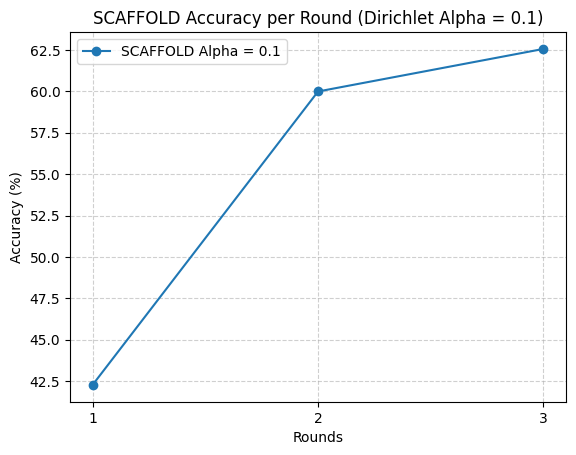

In [27]:
plt.figure()
plt.plot(range(1, rounds + 1), scaffold_accuracies, marker='o', label='SCAFFOLD Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()

# Task 5: FedSam



In this task, you will explore Sharpness-Aware Minimization (SAM) in a federated learning setting by implementing the FedSAM algorithm. As with previous tasks, evaluate its performance in a 0.1 Dirichlet heterogeneous scenario.

In [9]:
import time

import torch

import torch.nn as nn



# Select the best available device: CUDA, MPS, or CPU

device = torch.device("cuda" if torch.cuda.is_available() else

                      "mps" if torch.backends.mps.is_available() else

                      "cpu")

print(f"Using device: {device}")



def apply_sam_perturbation(model, criterion, x_train, y_train, rho):

    original_weights = {name: param.detach().clone() for name, param in model.named_parameters() if param.requires_grad}



    outputs = model(x_train)

    loss = criterion(outputs, y_train)

    loss.backward()



    with torch.no_grad():

        for name, param in model.named_parameters():

            if param.requires_grad:

                grad_norm = param.grad.norm(2)

                perturbation = rho * param.grad / (grad_norm + 1e-8)

                param.add_(perturbation)



    perturbed_weights = {name: param.clone() for name, param in model.named_parameters() if param.requires_grad}



    with torch.no_grad():

        for name, param in model.named_parameters():

            if param.requires_grad:

                param.copy_(original_weights[name])



    return perturbed_weights



def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):

    model.to(device)  # Move model to selected device

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()



    for epoch in range(epochs):

        epoch_start_time = time.time()



        for x_batch, y_batch in train_loader:

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to selected device



            perturbed_weights = apply_sam_perturbation(model, criterion, x_batch, y_batch, rho)



            optimizer.zero_grad()

            perturbed_outputs = model(x_batch)

            loss = criterion(perturbed_outputs, y_batch)

            loss.backward()

            optimizer.step()



        epoch_end_time = time.time()

        print(f"Epoch {epoch + 1} completed in {epoch_end_time - epoch_start_time:.2f} seconds")



    return {name: param.clone() for name, param in model.named_parameters()}



def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, rho=0.0001):

    global_model_state = global_model.state_dict()

    round_accuracies = []



    for round in range(rounds):

        round_start_time = time.time()

        client_updates = []



        for client_id in range(num_clients):

            local_model = SimpleCNN()

            local_model.load_state_dict(global_model_state)

            local_model.to(device)



            local_update = local_train_sam(local_model, train_loaders[client_id], epochs, local_lr, rho)

            client_updates.append(local_update)



        global_model_state = {name: sum(client_update[name] for client_update in client_updates) / num_clients

                              for name in global_model_state}



        global_model.load_state_dict(global_model_state)



        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)

        round_accuracies.append(total_accuracy)



        round_end_time = time.time()

        print(f"Round {round + 1}: Accuracy = {total_accuracy:.4f}, Time: {round_end_time - round_start_time:.2f} seconds")



    return round_accuracies



def evaluate_model(global_model, test_loaders):

    global_model.eval()

    global_model.to(device)

    client_accuracies = []

    total_correct, total_samples = 0, 0



    with torch.no_grad():

        for client_id, test_loader in enumerate(test_loaders):

            client_correct, client_total = 0, 0

            print(f"\nEvaluating Client {client_id}")



            for images, labels in test_loader:

                images, labels = images.to(device), labels.to(device)

                outputs = global_model(images)

                _, predicted = torch.max(outputs, 1)



                client_correct += (predicted == labels).sum().item()

                client_total += labels.size(0)



            client_accuracy = (client_correct / client_total) * 100

            client_accuracies.append(client_accuracy)



            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")



            total_correct += client_correct

            total_samples += client_total



    total_accuracy = (total_correct / total_samples) * 100

    print(f"Total Accuracy: {total_accuracy:.2f}%")

    return client_accuracies, total_accuracy


Using device: cuda


Comparisions at different hetrogenity levels

In [15]:
import matplotlib.pyplot as plt



# Parameters

num_clients = 5

batch_size = 128

rounds = 3

epochs = 20

lr = 0.001

dirichlet_alphas = [2, 0.5, 0.1]  # Heterogeneity levels



# Function to run FedAvg for a specific alpha

def run_fedavg(alpha):

    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)

    global_model_fedavg = SimpleCNN()

    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)

    return round_accuracies



# Function to run FedSAM for a specific alpha

def run_fedsam(alpha):

    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)

    global_model_sam = SimpleCNN()

    round_accuracies = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)

    return round_accuracies



# Run experiments for FedAvg and FedSAM at each alpha

accuracies_fedavg = {}

accuracies_fedsam = {}



for alpha in dirichlet_alphas:

    accuracies_fedavg[alpha] = run_fedavg(alpha)

    accuracies_fedsam[alpha] = run_fedsam(alpha)



# # Plot the results on a single graph

# plt.figure(figsize=(10, 6))



# for alpha in dirichlet_alphas:

#     plt.plot(range(1, rounds + 1), accuracies_fedavg[alpha], label=f'FedAvg α={alpha}')

#     plt.plot(range(1, rounds + 1), accuracies_fedsam[alpha], linestyle='--', label=f'FedSAM α={alpha}')



# plt.xlabel('Rounds')

# plt.ylabel('Test Accuracy')

# plt.title('Comparison of FedAvg and FedSAM Across Heterogeneity Levels')

# plt.legend()

# plt.grid(True)

# plt.show()



Round 1/3
  Client 1/5
Epoch 1/20 completed in 0.17 seconds.
Epoch 2/20 completed in 0.16 seconds.
Epoch 3/20 completed in 0.16 seconds.
Epoch 4/20 completed in 0.16 seconds.
Epoch 5/20 completed in 0.15 seconds.
Epoch 6/20 completed in 0.16 seconds.
Epoch 7/20 completed in 0.16 seconds.
Epoch 8/20 completed in 0.16 seconds.
Epoch 9/20 completed in 0.16 seconds.
Epoch 10/20 completed in 0.15 seconds.
Epoch 11/20 completed in 0.15 seconds.
Epoch 12/20 completed in 0.15 seconds.
Epoch 13/20 completed in 0.16 seconds.
Epoch 14/20 completed in 0.16 seconds.
Epoch 15/20 completed in 0.16 seconds.
Epoch 16/20 completed in 0.16 seconds.
Epoch 17/20 completed in 0.16 seconds.
Epoch 18/20 completed in 0.16 seconds.
Epoch 19/20 completed in 0.16 seconds.
Epoch 20/20 completed in 0.16 seconds.
  Client 2/5
Epoch 1/20 completed in 0.22 seconds.
Epoch 2/20 completed in 0.22 seconds.
Epoch 3/20 completed in 0.22 seconds.
Epoch 4/20 completed in 0.23 seconds.
Epoch 5/20 completed in 0.22 seconds.
Ep

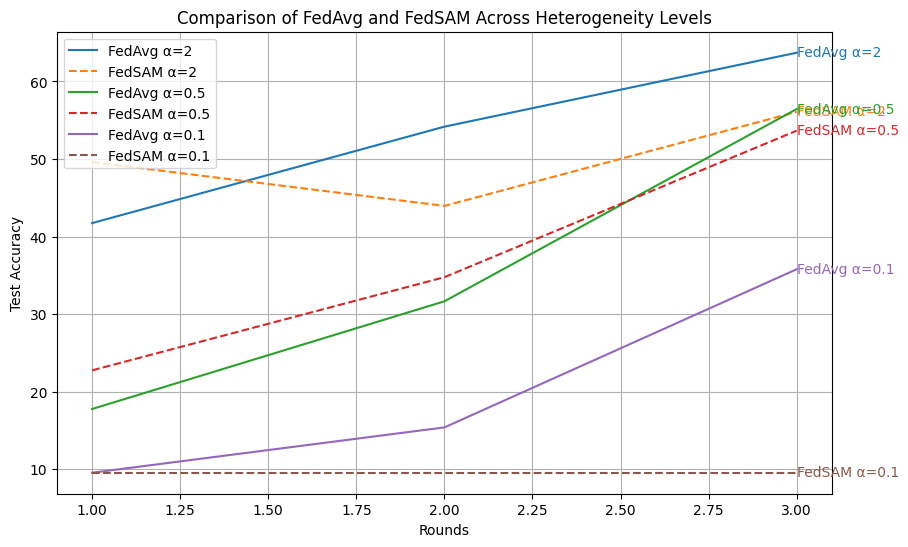

In [16]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 6))



# Create the plot and add labels to the lines

for alpha in dirichlet_alphas:

    # Plot FedAvg and FedSAM for each alpha

    fedavg_line, = plt.plot(range(1, rounds + 1), accuracies_fedavg[alpha], label=f'FedAvg α={alpha}')

    fedsam_line, = plt.plot(range(1, rounds + 1), accuracies_fedsam[alpha], linestyle='--', label=f'FedSAM α={alpha}')



    # Add labels to the lines for better visibility

    # You can adjust the position based on the graph size and values

    plt.text(rounds, accuracies_fedavg[alpha][-1], f'FedAvg α={alpha}', color=fedavg_line.get_color(),

             verticalalignment='center', horizontalalignment='left', fontsize=10)

    plt.text(rounds, accuracies_fedsam[alpha][-1], f'FedSAM α={alpha}', color=fedsam_line.get_color(),

             verticalalignment='center', horizontalalignment='left', fontsize=10)



plt.xlabel('Rounds')

plt.ylabel('Test Accuracy')

plt.title('Comparison of FedAvg and FedSAM Across Heterogeneity Levels')

plt.legend()

plt.grid(True)

plt.show()


client deviation


Testing original sharpness measure

Round 1
Epoch 1 completed in 0.51 seconds
Epoch 2 completed in 0.45 seconds
Epoch 3 completed in 0.48 seconds
Epoch 4 completed in 0.49 seconds
Epoch 5 completed in 0.49 seconds
Epoch 6 completed in 0.53 seconds
Epoch 7 completed in 0.49 seconds
Epoch 8 completed in 0.61 seconds
Epoch 9 completed in 0.53 seconds
Epoch 10 completed in 0.60 seconds
Epoch 11 completed in 0.63 seconds
Epoch 12 completed in 0.48 seconds
Epoch 13 completed in 0.46 seconds
Epoch 14 completed in 0.48 seconds
Epoch 15 completed in 0.46 seconds
Epoch 16 completed in 0.45 seconds
Epoch 17 completed in 0.44 seconds
Epoch 18 completed in 0.45 seconds
Epoch 19 completed in 0.53 seconds
Epoch 20 completed in 0.50 seconds
Epoch 1 completed in 0.26 seconds
Epoch 2 completed in 0.27 seconds
Epoch 3 completed in 0.29 seconds
Epoch 4 completed in 0.26 seconds
Epoch 5 completed in 0.28 seconds
Epoch 6 completed in 0.27 seconds
Epoch 7 completed in 0.31 seconds
Epoch 8 completed in 0.25 

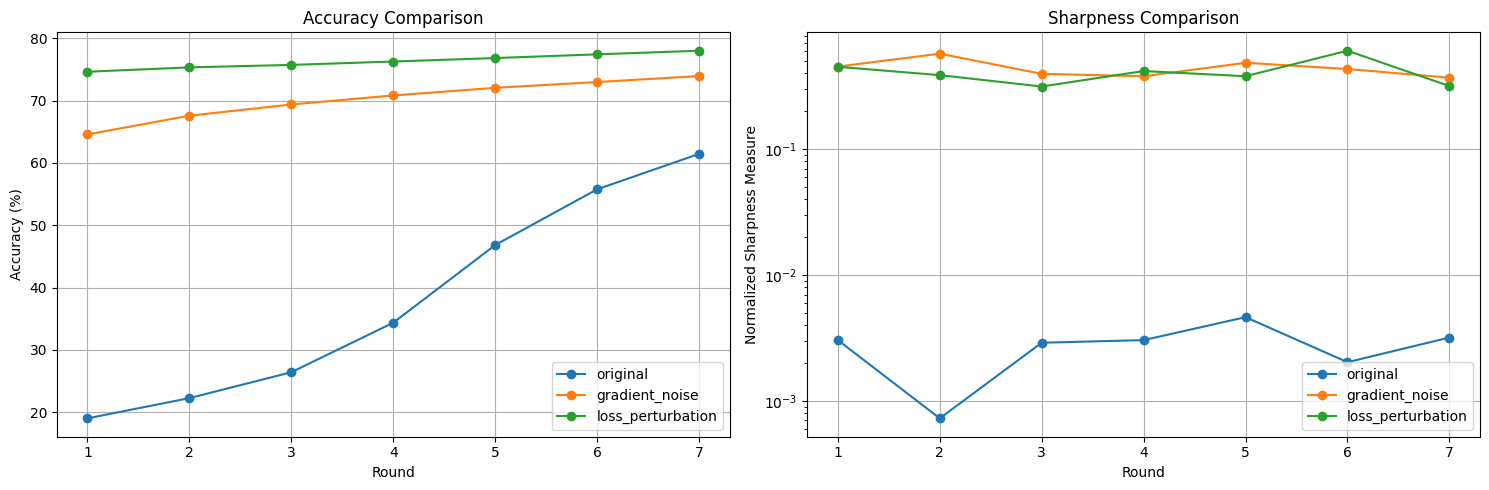

In [ ]:
import torch

import torch.nn as nn

import numpy as np

from torch.autograd import grad

import matplotlib.pyplot as plt



# Ensure this method exists in your codebase, or replace it with the correct data partitioning

train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)



class SharpnessMeasures:

    def __init__(self, model, criterion, device):

        self.model = model

        self.criterion = criterion

        self.device = device



    def original_sam_sharpness(self, x_train, y_train, rho):

        """Original SAM sharpness measure: ρ ∇Li(w) / ||∇Li(w)||"""

        self.model.train()

        self.model.zero_grad()



        outputs = self.model(x_train)

        loss = self.criterion(outputs, y_train)

        loss.backward()



        total_sharpness = 0

        for param in self.model.parameters():

            if param.grad is not None:

                grad_norm = param.grad.norm(2)

                if grad_norm.item() == 0:

                    print("Warning: Gradient norm is zero for a parameter.")

                sharpness = rho * param.grad / (grad_norm + 1e-8)

                total_sharpness += sharpness.norm(2).item()



        return total_sharpness



    def gradient_noise_sharpness(self, x_train, y_train, num_samples=5):

        """Measure sharpness by computing gradient variance"""

        self.model.train()

        batch_size = x_train.size(0)

        gradients = []



        for _ in range(num_samples):

            indices = torch.randperm(batch_size)[:batch_size // 2]

            x_sample = x_train[indices]

            y_sample = y_train[indices]



            self.model.zero_grad()

            outputs = self.model(x_sample)

            loss = self.criterion(outputs, y_sample)

            loss.backward()



            current_grads = []

            for param in self.model.parameters():

                if param.grad is not None:

                    current_grads.append(param.grad.clone().view(-1))

            gradients.append(torch.cat(current_grads))



        gradients = torch.stack(gradients)

        variance = torch.var(gradients, dim=0).mean().item()

        return variance



    def loss_perturbation_sharpness(self, x_train, y_train, epsilon=0.01, num_directions=3):

        """Measure sharpness by random parameter perturbations"""

        self.model.train()

        original_params = {name: param.clone() for name, param in self.model.named_parameters()}

        base_outputs = self.model(x_train)

        base_loss = self.criterion(base_outputs, y_train).item()



        perturbation_losses = []



        for _ in range(num_directions):

            with torch.no_grad():

                for param in self.model.parameters():

                    noise = torch.randn_like(param) * epsilon

                    param.add_(noise)



            perturbed_outputs = self.model(x_train)

            perturbed_loss = self.criterion(perturbed_outputs, y_train).item()

            perturbation_losses.append(abs(perturbed_loss - base_loss))



            with torch.no_grad():

                for name, param in self.model.named_parameters():

                    param.copy_(original_params[name])



        avg_perturbation_loss = np.mean(perturbation_losses)

        return avg_perturbation_loss



def modified_federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs,

                                    local_lr, rho=0.0001, sharpness_type='original'):

    global_model_state = global_model.state_dict()

    round_accuracies = []

    sharpness_measures = []

    criterion = nn.CrossEntropyLoss()



    for round in range(rounds):

        print(f"\nRound {round + 1}")

        client_updates = []

        round_sharpness = []



        for client_id in range(num_clients):

            local_model = type(global_model)()

            local_model.load_state_dict(global_model_state)

            local_model.to(device)



            sharpness_calculator = SharpnessMeasures(local_model, criterion, device)



            for x_batch, y_batch in train_loaders[client_id]:

                x_batch, y_batch = x_batch.to(device), y_batch.to(device)



                if sharpness_type == 'original':

                    sharpness = sharpness_calculator.original_sam_sharpness(x_batch, y_batch, rho)

                elif sharpness_type == 'gradient_noise':

                    sharpness = sharpness_calculator.gradient_noise_sharpness(x_batch, y_batch)

                elif sharpness_type == 'loss_perturbation':

                    sharpness = sharpness_calculator.loss_perturbation_sharpness(x_batch, y_batch)



                round_sharpness.append(sharpness)

                break



            local_update = local_train_sam(local_model, train_loaders[client_id], epochs, local_lr, rho)

            client_updates.append(local_update)



        global_model_state = {name: sum(client_update[name] for client_update in client_updates) / num_clients

                            for name in global_model_state}

        global_model.load_state_dict(global_model_state)



        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)

        round_accuracies.append(total_accuracy)



        normalized_sharpness = (round_sharpness - np.min(round_sharpness)) / (np.max(round_sharpness) - np.min(round_sharpness) + 1e-8)

        sharpness_measures.append(np.mean(normalized_sharpness))

        print(f"Round {round + 1} - Accuracy: {total_accuracy:.2f}%, Normalized Sharpness: {np.mean(normalized_sharpness):.4f}")



    return round_accuracies, sharpness_measures



def visualize_comparison(accuracies_dict, sharpness_dict):

    """Visualize accuracy and sharpness measures for different approaches"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))



    for method, accs in accuracies_dict.items():

        ax1.plot(range(1, len(accs) + 1), accs, marker='o', label=method)

    ax1.set_xlabel('Round')

    ax1.set_ylabel('Accuracy (%)')

    ax1.set_title('Accuracy Comparison')

    ax1.legend()

    ax1.grid(True)



    for method, sharp in sharpness_dict.items():

        ax2.plot(range(1, len(sharp) + 1), sharp, marker='o', label=method)

    ax2.set_ylabel('Normalized Sharpness Measure')

    ax2.set_yscale('log')

    ax2.set_xlabel('Round')

    ax2.set_title('Sharpness Comparison')

    ax2.legend()

    ax2.grid(True)



    plt.tight_layout()

    return fig



# Example usage

global_model = SimpleCNN()

results = {}

sharpness_results = {}



for measure in ['original', 'gradient_noise', 'loss_perturbation']:

    print(f"\nTesting {measure} sharpness measure")

    accuracies, sharpness = modified_federated_training_sam(

        global_model, train_loaders, test_loaders,

        num_clients=5, rounds=7, epochs=20, local_lr=0.001,

        sharpness_type=measure

    )

    results[measure] = accuracies

    sharpness_results[measure] = sharpness



fig = visualize_comparison(results, sharpness_results)

plt.show()



Testing original sharpness measure

Round 1
Epoch 1 completed in 0.61 seconds
Epoch 2 completed in 0.45 seconds
Epoch 3 completed in 0.44 seconds
Epoch 4 completed in 0.45 seconds
Epoch 5 completed in 0.44 seconds
Epoch 6 completed in 0.58 seconds
Epoch 7 completed in 0.89 seconds
Epoch 8 completed in 0.84 seconds
Epoch 9 completed in 0.56 seconds
Epoch 10 completed in 0.61 seconds
Epoch 11 completed in 0.48 seconds
Epoch 12 completed in 0.45 seconds
Epoch 13 completed in 0.45 seconds
Epoch 14 completed in 0.43 seconds
Epoch 15 completed in 0.48 seconds
Epoch 16 completed in 0.43 seconds
Epoch 17 completed in 0.43 seconds
Epoch 18 completed in 0.44 seconds
Epoch 19 completed in 0.43 seconds
Epoch 20 completed in 0.45 seconds
Epoch 1 completed in 0.24 seconds
Epoch 2 completed in 0.24 seconds
Epoch 3 completed in 0.24 seconds
Epoch 4 completed in 0.25 seconds
Epoch 5 completed in 0.24 seconds
Epoch 6 completed in 0.25 seconds
Epoch 7 completed in 0.25 seconds
Epoch 8 completed in 0.26 

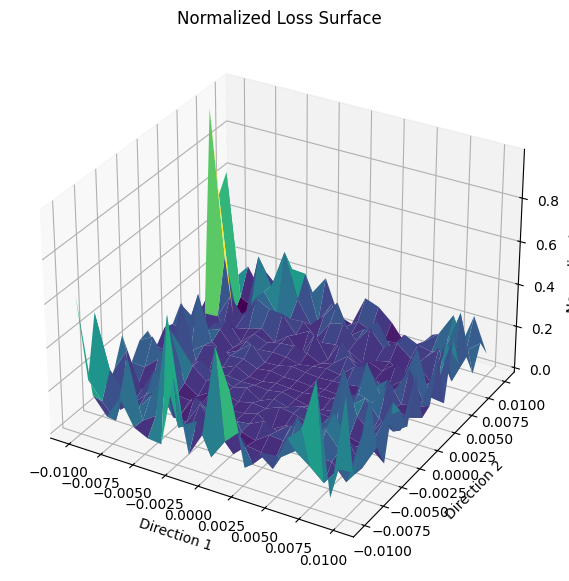


Testing gradient_noise sharpness measure

Round 1
Epoch 1 completed in 0.44 seconds
Epoch 2 completed in 0.43 seconds
Epoch 3 completed in 0.44 seconds
Epoch 4 completed in 0.43 seconds
Epoch 5 completed in 0.45 seconds
Epoch 6 completed in 0.43 seconds
Epoch 7 completed in 0.43 seconds
Epoch 8 completed in 0.44 seconds
Epoch 9 completed in 0.43 seconds
Epoch 10 completed in 0.43 seconds
Epoch 11 completed in 0.43 seconds
Epoch 12 completed in 0.45 seconds
Epoch 13 completed in 0.48 seconds
Epoch 14 completed in 0.56 seconds
Epoch 15 completed in 0.54 seconds
Epoch 16 completed in 0.61 seconds
Epoch 17 completed in 0.53 seconds
Epoch 18 completed in 0.44 seconds
Epoch 19 completed in 0.43 seconds
Epoch 20 completed in 0.43 seconds
Epoch 1 completed in 0.24 seconds
Epoch 2 completed in 0.24 seconds
Epoch 3 completed in 0.25 seconds
Epoch 4 completed in 0.24 seconds
Epoch 5 completed in 0.25 seconds
Epoch 6 completed in 0.24 seconds
Epoch 7 completed in 0.24 seconds
Epoch 8 completed in

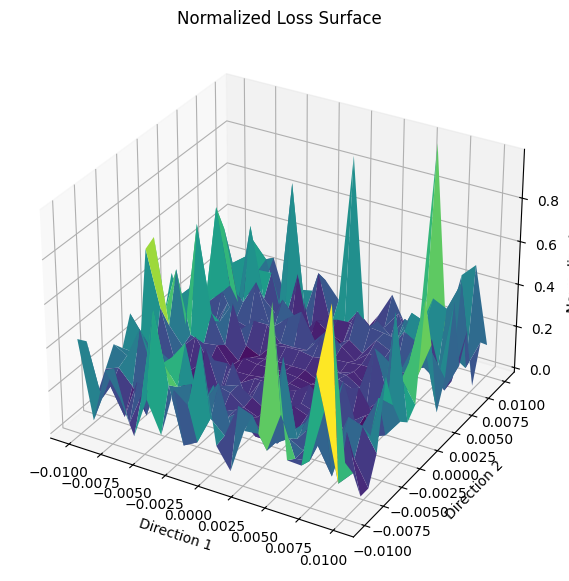


Testing loss_perturbation sharpness measure

Round 1
Epoch 1 completed in 0.45 seconds
Epoch 2 completed in 0.43 seconds
Epoch 3 completed in 0.43 seconds
Epoch 4 completed in 0.44 seconds
Epoch 5 completed in 0.43 seconds
Epoch 6 completed in 0.44 seconds
Epoch 7 completed in 0.43 seconds
Epoch 8 completed in 0.46 seconds
Epoch 9 completed in 0.44 seconds
Epoch 10 completed in 0.44 seconds
Epoch 11 completed in 0.45 seconds
Epoch 12 completed in 0.43 seconds
Epoch 13 completed in 0.45 seconds
Epoch 14 completed in 0.43 seconds
Epoch 15 completed in 0.46 seconds
Epoch 16 completed in 0.43 seconds
Epoch 17 completed in 0.44 seconds
Epoch 18 completed in 0.45 seconds
Epoch 19 completed in 0.50 seconds
Epoch 20 completed in 0.56 seconds
Epoch 1 completed in 0.30 seconds
Epoch 2 completed in 0.31 seconds
Epoch 3 completed in 0.35 seconds
Epoch 4 completed in 0.35 seconds
Epoch 5 completed in 0.29 seconds
Epoch 6 completed in 0.25 seconds
Epoch 7 completed in 0.24 seconds
Epoch 8 completed

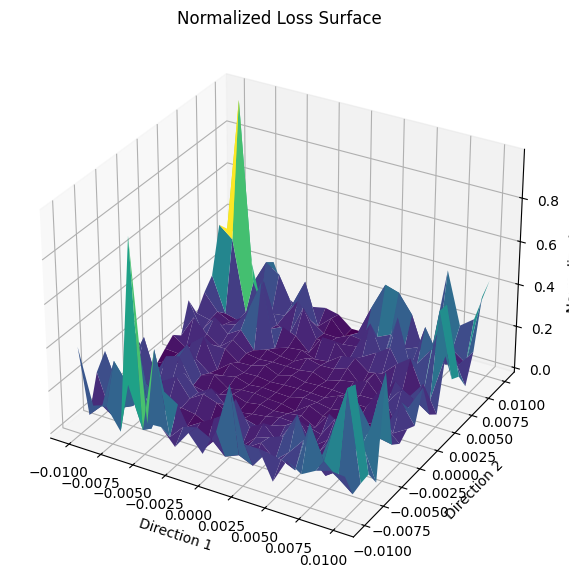

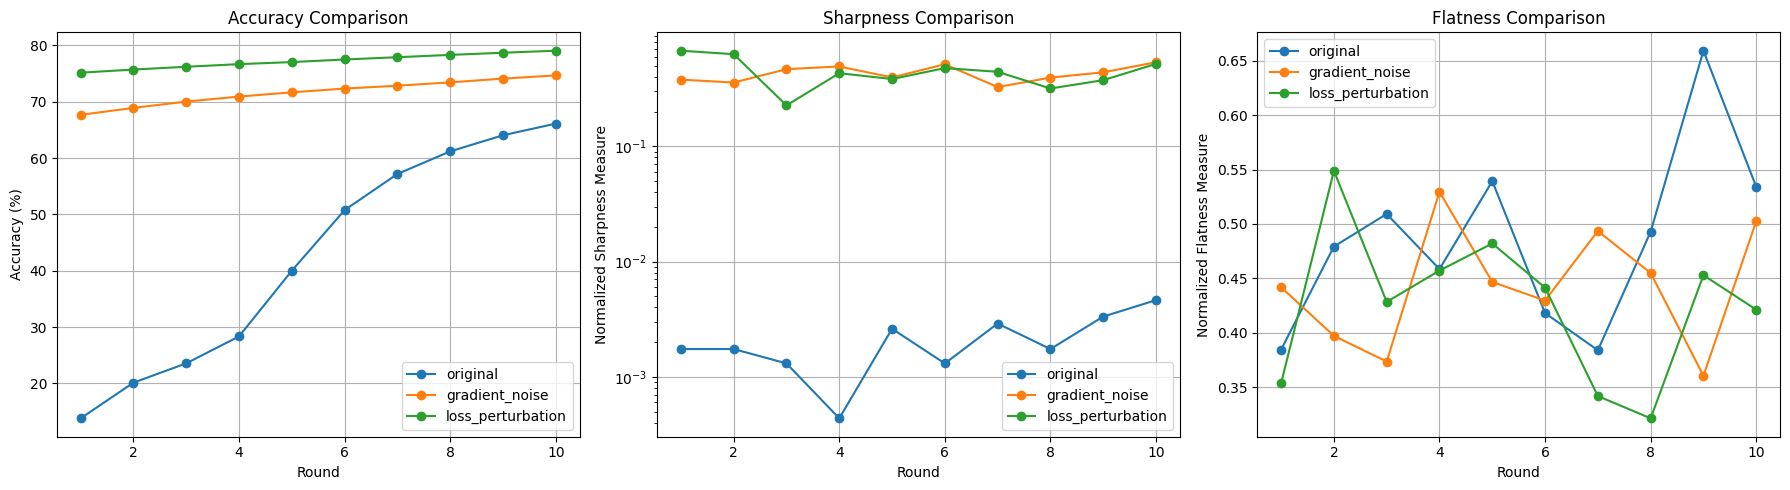

In [38]:
import torch

import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt



class SharpnessMeasures:

    def __init__(self, model, criterion, device):

        self.model = model

        self.criterion = criterion

        self.device = device



    # Original SAM sharpness

    def original_sam_sharpness(self, x_train, y_train, rho):

        self.model.train()

        self.model.zero_grad()



        outputs = self.model(x_train)

        loss = self.criterion(outputs, y_train)

        loss.backward()



        total_sharpness = 0

        for param in self.model.parameters():

            if param.grad is not None:

                grad_norm = param.grad.norm(2)

                sharpness = rho * param.grad / (grad_norm + 1e-8)

                total_sharpness += sharpness.norm(2).item()



        return total_sharpness



    # Gradient noise sharpness

    def gradient_noise_sharpness(self, x_train, y_train, num_samples=5):

        self.model.train()

        batch_size = x_train.size(0)

        gradients = []



        for _ in range(num_samples):

            indices = torch.randperm(batch_size)[:batch_size // 2]

            x_sample = x_train[indices]

            y_sample = y_train[indices]



            self.model.zero_grad()

            outputs = self.model(x_sample)

            loss = self.criterion(outputs, y_sample)

            loss.backward()



            current_grads = []

            for param in self.model.parameters():

                if param.grad is not None:

                    current_grads.append(param.grad.clone().view(-1))

            gradients.append(torch.cat(current_grads))



        gradients = torch.stack(gradients)

        variance = torch.var(gradients, dim=0).mean().item()

        return variance



    # Loss perturbation sharpness

    def loss_perturbation_sharpness(self, x_train, y_train, epsilon=0.01, num_directions=3):

        self.model.train()

        original_params = {name: param.clone() for name, param in self.model.named_parameters()}

        base_outputs = self.model(x_train)

        base_loss = self.criterion(base_outputs, y_train).item()



        perturbation_losses = []



        for _ in range(num_directions):

            with torch.no_grad():

                for param in self.model.parameters():

                    noise = torch.randn_like(param) * epsilon

                    param.add_(noise)



            perturbed_outputs = self.model(x_train)

            perturbed_loss = self.criterion(perturbed_outputs, y_train).item()

            perturbation_losses.append(abs(perturbed_loss - base_loss))



            with torch.no_grad():

                for name, param in self.model.named_parameters():

                    param.copy_(original_params[name])



        avg_perturbation_loss = np.mean(perturbation_losses)

        return avg_perturbation_loss



    # Flatness measure: Loss variation under parameter perturbation

    def flatness_measure(self, x_train, y_train, epsilon=0.01, num_directions=3):

        self.model.train()

        original_params = {name: param.clone() for name, param in self.model.named_parameters()}

        base_outputs = self.model(x_train)

        base_loss = self.criterion(base_outputs, y_train).item()



        perturbation_losses = []



        for _ in range(num_directions):

            with torch.no_grad():

                for param in self.model.parameters():

                    noise = torch.randn_like(param) * epsilon

                    param.add_(noise)



            perturbed_outputs = self.model(x_train)

            perturbed_loss = self.criterion(perturbed_outputs, y_train).item()

            perturbation_losses.append(abs(perturbed_loss - base_loss))



            with torch.no_grad():

                for name, param in self.model.named_parameters():

                    param.copy_(original_params[name])



        avg_perturbation_loss = np.mean(perturbation_losses)

        return avg_perturbation_loss



    # Plotting loss surface

    def plot_loss_surface(self, x_train, y_train, epsilon=0.01, num_points=20):

      self.model.eval()

      base_loss = self.criterion(self.model(x_train), y_train).item()



      perturbation_vals = np.linspace(-epsilon, epsilon, num_points)

      loss_surface = np.zeros((num_points, num_points))



      # Compute the loss surface with perturbations

      for i, val_x in enumerate(perturbation_vals):

          for j, val_y in enumerate(perturbation_vals):

              with torch.no_grad():

                  perturbed_params = {name: param.clone() for name, param in self.model.named_parameters()}

                  for param in self.model.parameters():

                      param.add_(val_x * torch.randn_like(param) + val_y * torch.randn_like(param))



                  loss_surface[i, j] = self.criterion(self.model(x_train), y_train).item()



                  # Restore original params

                  for name, param in self.model.named_parameters():

                      param.copy_(perturbed_params[name])



      # Normalize the loss surface to the [0, 1] range

      loss_surface = (loss_surface - np.min(loss_surface)) / (np.max(loss_surface) - np.min(loss_surface) + 1e-8)



      # Plotting the loss surface

      X, Y = np.meshgrid(perturbation_vals, perturbation_vals)

      fig = plt.figure(figsize=(10, 7))

      ax = fig.add_subplot(111, projection='3d')

      ax.plot_surface(X, Y, loss_surface, cmap='viridis')

      ax.set_xlabel('Direction 1')

      ax.set_ylabel('Direction 2')

      ax.set_zlabel('Normalized Loss')

      ax.set_title('Normalized Loss Surface')

      plt.show()











def visualize_comparison(accuracies_dict, sharpness_dict, flatness_dict):

    """Visualize accuracy, sharpness, and flatness measures for different approaches"""

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))



    # Accuracy plot

    for method, accs in accuracies_dict.items():

        ax1.plot(range(1, len(accs) + 1), accs, marker='o', label=method)

    ax1.set_xlabel('Round')

    ax1.set_ylabel('Accuracy (%)')

    ax1.set_title('Accuracy Comparison')

    ax1.legend()

    ax1.grid(True)



    # Sharpness plot

    for method, sharp in sharpness_dict.items():

        ax2.plot(range(1, len(sharp) + 1), sharp, marker='o', label=method)

    ax2.set_ylabel('Normalized Sharpness Measure')

    ax2.set_yscale('log')

    ax2.set_xlabel('Round')

    ax2.set_title('Sharpness Comparison')

    ax2.legend()

    ax2.grid(True)



    # Flatness plot

    for method, flat in flatness_dict.items():

        ax3.plot(range(1, len(flat) + 1), flat, marker='o', label=method)

    ax3.set_ylabel('Normalized Flatness Measure')

    ax3.set_xlabel('Round')

    ax3.set_title('Flatness Comparison')

    ax3.legend()

    ax3.grid(True)



    plt.tight_layout()

    return fig





def modified_federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs,

                                    local_lr, rho=0.0001, sharpness_type='original'):

    global_model_state = global_model.state_dict()

    round_accuracies = []

    sharpness_measures = []

    flatness_measures = []  # To store flatness measures

    criterion = nn.CrossEntropyLoss()

    final_x_batch, final_y_batch = None, None  # Variables to store data for plotting loss surface



    for round in range(rounds):

        print(f"\nRound {round + 1}")

        client_updates = []

        round_sharpness = []

        round_flatness = []  # To track flatness for each round



        for client_id in range(num_clients):

            # Reset the model for each method

            local_model = type(global_model)()  # Reinitialize the model (this ensures a fresh model)

            local_model.load_state_dict(global_model_state)  # Load global model state

            local_model.to(device)



            sharpness_calculator = SharpnessMeasures(local_model, criterion, device)



            for x_batch, y_batch in train_loaders[client_id]:

                x_batch, y_batch = x_batch.to(device), y_batch.to(device)



                # Store a batch from the final round for plotting the loss surface

                if round == rounds - 1:

                    final_x_batch, final_y_batch = x_batch, y_batch



                if sharpness_type == 'original':

                    sharpness = sharpness_calculator.original_sam_sharpness(x_batch, y_batch, rho)

                elif sharpness_type == 'gradient_noise':

                    sharpness = sharpness_calculator.gradient_noise_sharpness(x_batch, y_batch)

                elif sharpness_type == 'loss_perturbation':

                    sharpness = sharpness_calculator.loss_perturbation_sharpness(x_batch, y_batch)



                round_sharpness.append(sharpness)



                # Flatness computation

                flatness = sharpness_calculator.flatness_measure(x_batch, y_batch)

                round_flatness.append(flatness)



                # Break after one batch per client

                break



            local_update = local_train_sam(local_model, train_loaders[client_id], epochs, local_lr, rho)

            client_updates.append(local_update)



        # Update global model with average of client updates

        global_model_state = {name: sum(client_update[name] for client_update in client_updates) / num_clients

                            for name in global_model_state}

        global_model.load_state_dict(global_model_state)



        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)

        round_accuracies.append(total_accuracy)



        # Normalizing and storing sharpness and flatness measures

        normalized_sharpness = (round_sharpness - np.min(round_sharpness)) / (np.max(round_sharpness) - np.min(round_sharpness) + 1e-8)

        sharpness_measures.append(np.mean(normalized_sharpness))



        normalized_flatness = (round_flatness - np.min(round_flatness)) / (np.max(round_flatness) - np.min(round_flatness) + 1e-8)

        flatness_measures.append(np.mean(normalized_flatness))



        print(f"Round {round + 1} - Accuracy: {total_accuracy:.2f}%, Normalized Sharpness: {np.mean(normalized_sharpness):.4f}, Normalized Flatness: {np.mean(normalized_flatness):.4f}")



    # Plot loss surface after all rounds using the last batch from the final round

    if rounds > 0 and final_x_batch is not None and final_y_batch is not None:  # Ensure there are rounds and data to plot

        sharpness_calculator.plot_loss_surface(final_x_batch, final_y_batch, epsilon=0.01, num_points=20)



    return round_accuracies, sharpness_measures, flatness_measures







# Running federated training for each sharpness measure

results = {}

sharpness_results = {}

flatness_results = {}

global_model = SimpleCNN()



for measure in ['original', 'gradient_noise', 'loss_perturbation']:

    print(f"\nTesting {measure} sharpness measure")

    accuracies, sharpness, flatness = modified_federated_training_sam(

        global_model, train_loaders, test_loaders,

        num_clients=5, rounds=10, epochs=20, local_lr=0.001,

        sharpness_type=measure

    )

    results[measure] = accuracies

    sharpness_results[measure] = sharpness

    flatness_results[measure] = flatness



fig = visualize_comparison(results, sharpness_results, flatness_results)

plt.show()






In [ ]:
# Run the FedSAM experiment

num_clients = 5

rounds = 3

epochs = 20

lr = 0.001



def run_fedsam():

    # Partition data with a Dirichlet alpha of 0.1

    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)

    global_model_sam = SimpleCNN()

    round_accuracies = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)

    return round_accuracies



# Run FedSAM and get accuracy per round

sam_accuracies = run_fedsam()




Epoch 1 completed in 72.02 seconds
Epoch 2 completed in 67.41 seconds
Epoch 3 completed in 64.83 seconds
Epoch 4 completed in 64.00 seconds
Epoch 5 completed in 63.15 seconds
Epoch 6 completed in 64.74 seconds
Epoch 7 completed in 64.14 seconds
Epoch 8 completed in 65.19 seconds
Epoch 9 completed in 64.43 seconds
Epoch 10 completed in 62.88 seconds
Epoch 11 completed in 66.95 seconds
Epoch 12 completed in 69.22 seconds
Epoch 13 completed in 73.02 seconds
Epoch 14 completed in 69.98 seconds
Epoch 15 completed in 68.20 seconds
Epoch 16 completed in 69.13 seconds
Epoch 17 completed in 70.38 seconds
Epoch 18 completed in 69.47 seconds
Epoch 19 completed in 68.45 seconds
Epoch 20 completed in 66.90 seconds
Epoch 1 completed in 54.41 seconds
Epoch 2 completed in 54.15 seconds
Epoch 3 completed in 53.00 seconds
Epoch 4 completed in 55.12 seconds
Epoch 5 completed in 54.47 seconds
Epoch 6 completed in 53.82 seconds
Epoch 7 completed in 54.15 seconds
Epoch 8 completed in 55.80 seconds
Epoch 9 c

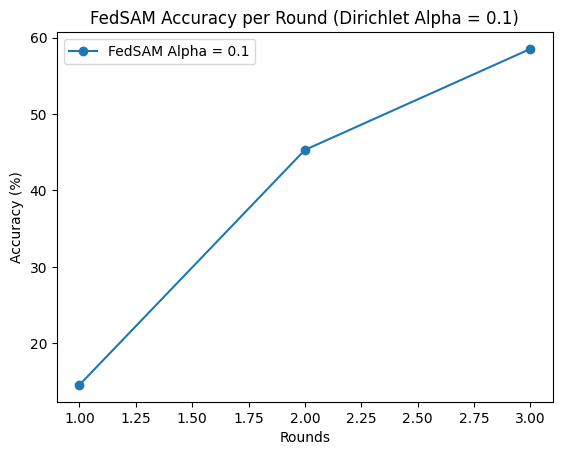

In [ ]:
# Plotting accuracy per round for FedSAM with Dirichlet alpha 0.1

plt.figure()

plt.plot(range(1, rounds + 1), sam_accuracies, marker='o', label='FedSAM Alpha = 0.1')

plt.xlabel('Rounds')

plt.ylabel('Accuracy (%)')

plt.title('FedSAM Accuracy per Round (Dirichlet Alpha = 0.1)')

plt.legend()

plt.show()